## 1. Importing Libraries

In [9]:
import shutil
import apiquery
import pandas as pd
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import os
import numpy as np
import random
DATA_PATH = '../01.Data'
shutil.copy("apiquery_pyc.py", "apiquery.pyc")
module_path = "../src"
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.training import *
from utils.encoding import *
from utils.utils import *

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
import math
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import math
import time
!pip install lightgbm
import lightgbm as lgbm
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [10]:
def feature_engineering(df):
    df['diff_t']  = df['last_modified_t']-df['created_t']
    df.drop(columns = ['last_modified_t','created_t'],inplace = True)

## 2. Preprocessing

In [11]:
%%time
# Reading dataframes
df_train     = pd.read_csv(os.path.join(DATA_PATH,'food_train.tsv'), index_col='Index', encoding='utf-8', sep='\t').reset_index(drop = True)
df_test      = pd.read_csv(os.path.join(DATA_PATH,'food_X_test.tsv'), index_col='Index', encoding='utf-8', sep='\t').reset_index()
df_test      = df_test.merge(pd.read_csv(os.path.join(DATA_PATH,'target_test.csv')),how = 'left',on = ['Index'])
y_submission = pd.read_csv(os.path.join(DATA_PATH,'y_test_submission_example.tsv'), index_col='Index', encoding='utf-8', sep='\t')


cols_extract_date = ['created_datetime','last_modified_datetime']
# Preprocessing
#2. 
multiple_extract_time(df_train,cols_extract_date)
multiple_extract_time(df_test,cols_extract_date)
#3. 
col = 'main_category'
df_train[[f'{col}_lang',f'{col}_cat']] = df_train.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_lang',f'{col}_cat']] = df_test.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')

col = 'main_category_en'
df_train[[f'{col}_lang',f'{col}_cat']] = df_train.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_lang',f'{col}_cat']] = df_test.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')


# Formating columns
format_cols = ['pnns_groups_1','pnns_groups_2','product_name','generic_name','packaging','packaging_tags','brands','brands_tags',
 'categories','categories_tags','origins','origins_tags','manufacturing_places','manufacturing_places_tags',
'labels','labels_tags','labels_en','emb_codes','emb_codes_tags','cities_tags','purchase_places','stores']
for i in format_cols :
    df_train[i] = df_train[i].apply(lambda x:func_formatting(x)) 
    df_test[i] = df_test[i].apply(lambda x:func_formatting(x))

# Extracting geo location:
df_train[[f'first_packaging_code_geo_x','first_packaging_code_geo_y']] = df_train.apply(lambda x: func_geolocation(x),axis = 1,result_type='expand')
df_test[[f'first_packaging_code_geo_x','first_packaging_code_geo_y']]  = df_test.apply(lambda x: func_geolocation(x),axis = 1,result_type='expand')
df_train.drop(columns = ['first_packaging_code_geo'],inplace = True)
df_test.drop(columns = ['first_packaging_code_geo'],inplace = True)

for i in ['countries_en','allergens']:
    df_train[i] = df_train[i].apply(lambda x:func_sort_split_comma(x))
    df_test[i]  = df_test[i].apply(lambda x:func_sort_split_comma(x))


cols_states_en = ['brands','categories','characteristics','expiration date','general_check','general_complete',
                 'ingredients','nutrition facts','packaging','packaging-code-','photo_upload','photo_validate',
                 'product name','quantity']
col = 'states_en'
df_train[[f'{col}_{idx}' for idx in cols_states_en]] = df_train.apply(lambda x: func_states(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_{idx}' for idx in cols_states_en]] = df_test.apply(lambda x: func_states(x,col),axis = 1,result_type='expand')

# Drop some cols
cols_drop = ['ingredients_that_may_be_from_palm_oil','ingredients_from_palm_oil','no_nutriments','allergens_en','cities',
            'generic_name','categories','categories_en','origins','manufacturing_places','labels',
             'emb_codes','emb_codes_tags','cities_tags','purchase_places','stores','countries',
             'countries_en','traces','traces_en','additives_en','ingredients_from_palm_oil_tags',
             'ingredients_that_may_be_from_palm_oil_tags','ingredients_that_may_be_from_palm_oil_tags',
             'states','states_tags','main_category','main_category_en','first_packaging_code_geo_x','first_packaging_code_geo_y']

#df_train.drop(columns = cols_drop,inplace = True)
#df_test.drop(columns = cols_drop,inplace = True)

col = 'additives'
df_train[col] = df_train[col].apply(lambda x:process_aditives(x))
df_test[col]  = df_test[col].apply(lambda x:process_aditives(x))

CPU times: user 40.9 s, sys: 1.1 s, total: 42 s
Wall time: 42 s


In [13]:
feature_engineering(df_train)
feature_engineering(df_test)

## 3. Model Split

In [14]:
num_bins = int(np.floor(1 + np.log2(len(df_train))))
#num_bins = 10
print(f'Num bins: {num_bins}')
df_train['target_bin'] = pd.qcut(df_train['target'],num_bins,labels = False)
100*df_train['target_bin'].value_counts(normalize = True)

Num bins: 17


2     9.675775
10    9.075940
7     7.143137
8     7.093151
0     6.863802
5     6.561924
14    5.904262
16    5.847414
12    5.708237
13    5.387737
3     5.083899
1     5.083899
4     4.741836
6     4.449759
15    3.983220
9     3.939115
11    3.456894
Name: target_bin, dtype: float64

In [15]:
FOLDS = 5
SEED  = 42

df_fold = df_train.copy()
skf = StratifiedKFold(n_splits = FOLDS,shuffle = True, random_state = SEED)
df_fold['fold'] = 0
for fold,(train_index, test_index) in enumerate(skf.split(df_fold,df_fold['target_bin'])):
    df_fold.loc[test_index,'fold'] = fold
    
# Save the CSV with folds for training
df_fold.to_csv(os.path.join("../01.Data",'fold.csv'),index = False)
df_test.to_csv(os.path.join(DATA_PATH,'test_preprocessed.csv'),index = False)

In [16]:
df_fold.groupby('fold')['target'].mean()

fold
0    9.167353
1    9.173527
2    9.168235
3    9.171870
4    9.172262
Name: target, dtype: float64

## 4. Modeling

In [8]:
%%time
df_train = pd.read_csv(os.path.join("../01.Data",'fold.csv'))
df_test      = pd.read_csv(os.path.join(DATA_PATH,'test_preprocessed.csv'))
y_submission = pd.read_csv(os.path.join(DATA_PATH,'y_test_submission_example.tsv'), index_col='Index', encoding='utf-8', sep='\t')

CPU times: user 2.94 s, sys: 351 ms, total: 3.3 s
Wall time: 4.56 s


In [12]:
columns_modeling = ['additives_n','ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n','target',
                    'states_en_brands','states_en_categories','states_en_characteristics','states_en_expiration date',
                    'states_en_general_complete','states_en_ingredients','pnns_groups_1','pnns_groups_2',
                    'states_en_packaging','states_en_packaging-code-','states_en_photo_upload',
                    'states_en_photo_validate','states_en_product name','states_en_quantity','diff_t']
columns_label = df_train[columns_modeling].select_dtypes(include=['object']).columns.to_list()
print(columns_label)

['states_en_brands', 'states_en_categories', 'states_en_characteristics', 'states_en_expiration date', 'states_en_general_complete', 'states_en_ingredients', 'pnns_groups_1', 'pnns_groups_2', 'states_en_packaging', 'states_en_packaging-code-', 'states_en_photo_upload', 'states_en_photo_validate', 'states_en_product name', 'states_en_quantity']


In [14]:
df_train,dict_le = label_encoding(df_train,label_cols = columns_label, drop_original = True, missing_new_cat = True)
df_test = apply_label_encoder(df_test,dict_le,drop_original = True, missing_new_cat = True)

Mode: Missing as new category
Label Encoding:  label_states_en_brands
Label Encoding:  label_states_en_categories
Label Encoding:  label_states_en_characteristics
Label Encoding:  label_states_en_expiration date
Label Encoding:  label_states_en_general_complete
Label Encoding:  label_states_en_ingredients
Label Encoding:  label_pnns_groups_1
Label Encoding:  label_pnns_groups_2
Label Encoding:  label_states_en_packaging
Label Encoding:  label_states_en_packaging-code-
Label Encoding:  label_states_en_photo_upload
Label Encoding:  label_states_en_photo_validate
Label Encoding:  label_states_en_product name
Label Encoding:  label_states_en_quantity
Mode: Missing as new category
Applying Label Encoding:  label_states_en_brands
Applying Label Encoding:  label_states_en_categories
Applying Label Encoding:  label_states_en_characteristics
Applying Label Encoding:  label_states_en_expiration date
Applying Label Encoding:  label_states_en_general_complete
Applying Label Encoding:  label_states

In [15]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'num_leaves':10,
        'learning_rate': 0.01,
        "min_child_samples": 150,
        "max_depth" : 5,
        'feature_fraction':  0.7,
        "bagging_freq": 1,
        'bagging_fraction': 0.75,
        "is_unbalance" : False,
        'force_col_wise':True,
        'num_threads':18,
        #"scale_pos_weight":5 -> Generally  is the ratio of number of negative class to the positive class.
        'bagging_seed':SEED,
        'lambda_l1':1.5,
        'lambda_l2':1,
        'verbose': 1

}
cat_columns = [i for i in df_train.columns.to_list() if i.startswith('label_')] +['created_datetime_year']
columns_modeling_last = list(set(columns_modeling)-set(columns_label)) + ['fold'] + cat_columns 
print(columns_modeling_last)

['diff_t', 'ingredients_from_palm_oil_n', 'target', 'additives_n', 'ingredients_that_may_be_from_palm_oil_n', 'fold', 'label_states_en_brands', 'label_states_en_categories', 'label_states_en_characteristics', 'label_states_en_expiration date', 'label_states_en_general_complete', 'label_states_en_ingredients', 'label_pnns_groups_1', 'label_pnns_groups_2', 'label_states_en_packaging', 'label_states_en_packaging-code-', 'label_states_en_photo_upload', 'label_states_en_photo_validate', 'label_states_en_product name', 'label_states_en_quantity', 'created_datetime_year']


In [16]:
results,models,importances,oof,feature_list = Training_Lightgbm(df_train[columns_modeling_last],params,fold_column = 'fold',target_column = 'target',cat_vars = cat_columns ,metric = 'RMSE',early_stopping = 200,max_boost_round = 8000)

Columns: ['diff_t', 'ingredients_from_palm_oil_n', 'additives_n', 'ingredients_that_may_be_from_palm_oil_n', 'label_states_en_brands', 'label_states_en_categories', 'label_states_en_characteristics', 'label_states_en_expiration date', 'label_states_en_general_complete', 'label_states_en_ingredients', 'label_pnns_groups_1', 'label_pnns_groups_2', 'label_states_en_packaging', 'label_states_en_packaging-code-', 'label_states_en_photo_upload', 'label_states_en_photo_validate', 'label_states_en_product name', 'label_states_en_quantity', 'created_datetime_year']
Cat index: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
---------- Training fold Nº 1 ----------
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 81622, number of used features: 19
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 8.28488	valid_1's rmse: 8.29514
[150]	training's rmse: 8.17413	valid_1's rmse: 8.18926
[200]	training's rmse: 8.11907	valid_1's rmse: 8.13754
[250]	training's rmse: 8.08934	valid_1's rmse: 8.11
[300]	training's rmse: 8.07389	valid_1's rmse: 8.09632
[350]	training's rmse: 8.06369	valid_1's rmse: 8.08725
[400]	training's rmse: 8.05641	valid_1's rmse: 8.08122
[450]	training's rmse: 8.05074	valid_1's rmse: 8.0765
[500]	training's rmse: 8.04579	valid_1's rmse: 8.07259
[550]	training's rmse: 8.04187	valid_1's rmse: 8.06952
[600]	training's rmse: 8.03834	valid_1's rmse: 8.06682
[650]	training's rmse: 8.03505	valid_1's rmse: 8.06444
[700]	training's rmse: 8.03213	valid_1's rmse: 8.06242
[750]	training's rmse: 8.0294	valid_1's rmse: 8.06055
[800]	training's rmse: 8.02709	valid_1's rmse: 8.05914
[850]	training's rmse: 8.02476	valid_1's rmse: 8.05752
[900]	training's rmse: 8.02255	valid_1's rmse: 8.05601
[950]	training's rmse: 8.02059	valid_1's rmse: 8.05485
[1000]	training

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 8.28431	valid_1's rmse: 8.29613
[150]	training's rmse: 8.1748	valid_1's rmse: 8.18859
[200]	training's rmse: 8.12016	valid_1's rmse: 8.13561
[250]	training's rmse: 8.09103	valid_1's rmse: 8.10779
[300]	training's rmse: 8.07535	valid_1's rmse: 8.09319
[350]	training's rmse: 8.06535	valid_1's rmse: 8.08416
[400]	training's rmse: 8.05826	valid_1's rmse: 8.07775
[450]	training's rmse: 8.05251	valid_1's rmse: 8.07268
[500]	training's rmse: 8.04799	valid_1's rmse: 8.06893
[550]	training's rmse: 8.04372	valid_1's rmse: 8.06541
[600]	training's rmse: 8.04021	valid_1's rmse: 8.06222
[650]	training's rmse: 8.03712	valid_1's rmse: 8.05962
[700]	training's rmse: 8.03444	valid_1's rmse: 8.05758
[750]	training's rmse: 8.03167	valid_1's rmse: 8.05554
[800]	training's rmse: 8.02948	valid_1's rmse: 8.05372
[850]	training's rmse: 8.0271	valid_1's rmse: 8.0518
[900]	training's rmse: 8.02497	valid_1's rmse: 8.05035
[950]	training's rmse: 8.0231	valid_1's rmse: 8.04889
[LightGBM] [Wa

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 8.28982	valid_1's rmse: 8.28107
[150]	training's rmse: 8.17996	valid_1's rmse: 8.17104
[200]	training's rmse: 8.1249	valid_1's rmse: 8.11555
[250]	training's rmse: 8.09558	valid_1's rmse: 8.08636
[300]	training's rmse: 8.07985	valid_1's rmse: 8.07107
[350]	training's rmse: 8.06975	valid_1's rmse: 8.0617
[400]	training's rmse: 8.06247	valid_1's rmse: 8.05496
[450]	training's rmse: 8.05644	valid_1's rmse: 8.04981
[500]	training's rmse: 8.05202	valid_1's rmse: 8.04631
[550]	training's rmse: 8.04779	valid_1's rmse: 8.04292
[600]	training's rmse: 8.04431	valid_1's rmse: 8.0405
[650]	training's rmse: 8.04128	valid_1's rmse: 8.03825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	training's rmse: 8.03846	valid_1's rmse: 8.03627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	training's rmse: 8.03558	valid_1's rmse: 8.03433
[800]	training's rmse: 8.03317	valid_1's rmse: 8.03269
[LightGBM] [Warning] No furt

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 8.28559	valid_1's rmse: 8.29583
[150]	training's rmse: 8.17517	valid_1's rmse: 8.18817
[200]	training's rmse: 8.11976	valid_1's rmse: 8.13463
[250]	training's rmse: 8.09017	valid_1's rmse: 8.10645
[300]	training's rmse: 8.07446	valid_1's rmse: 8.09246
[350]	training's rmse: 8.06422	valid_1's rmse: 8.08421
[400]	training's rmse: 8.05656	valid_1's rmse: 8.07853
[450]	training's rmse: 8.05046	valid_1's rmse: 8.07444
[500]	training's rmse: 8.04564	valid_1's rmse: 8.07148
[550]	training's rmse: 8.04132	valid_1's rmse: 8.06875
[600]	training's rmse: 8.03775	valid_1's rmse: 8.06668
[650]	training's rmse: 8.03448	valid_1's rmse: 8.06491
[700]	training's rmse: 8.03157	valid_1's rmse: 8.06345
[750]	training's rmse: 8.02874	valid_1's rmse: 8.06178
[800]	training's rmse: 8.02618	valid_1's rmse: 8.06038
[850]	training's rmse: 8.02377	valid_1's rmse: 8.05936
[900]	training's rmse: 8.02149	valid_1's rmse: 8.05819
[950]	training's rmse: 8.01941	valid_1's rmse: 8.05726
[1000]	tra

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 8.2904	valid_1's rmse: 8.28051
[150]	training's rmse: 8.18092	valid_1's rmse: 8.16742
[200]	training's rmse: 8.12641	valid_1's rmse: 8.11069
[250]	training's rmse: 8.09759	valid_1's rmse: 8.08071
[300]	training's rmse: 8.08227	valid_1's rmse: 8.06458
[350]	training's rmse: 8.07246	valid_1's rmse: 8.05445
[400]	training's rmse: 8.06513	valid_1's rmse: 8.04707
[450]	training's rmse: 8.05922	valid_1's rmse: 8.04131
[500]	training's rmse: 8.05469	valid_1's rmse: 8.03689
[550]	training's rmse: 8.0507	valid_1's rmse: 8.03318
[600]	training's rmse: 8.04732	valid_1's rmse: 8.0303
[650]	training's rmse: 8.04415	valid_1's rmse: 8.02774
[700]	training's rmse: 8.04132	valid_1's rmse: 8.02549
[750]	training's rmse: 8.03862	valid_1's rmse: 8.02333
[800]	training's rmse: 8.03619	valid_1's rmse: 8.02146
[850]	training's rmse: 8.03384	valid_1's rmse: 8.01976
[900]	training's rmse: 8.0318	valid_1's rmse: 8.01839
[950]	training's rmse: 8.02971	valid_1's rmse: 8.01701
[1000]	trainin

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


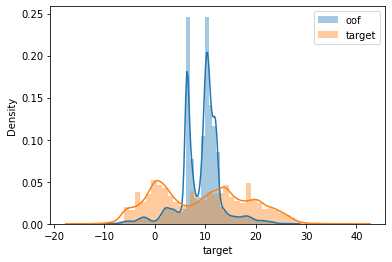

In [17]:
sns.distplot((oof),label = 'oof')
sns.distplot(df_train['target'],label = 'target')
plt.legend()
plt.show()

In [18]:
probs = 0
for i in models:
    probs = probs + (i.predict(df_test[feature_list]))
    
    print('fin_predict')
y_test_pred = probs/5.0
print(f'Real: ',math.sqrt(mean_squared_error(y_test_pred,df_test['Target'].values)))

fin_predict
fin_predict
fin_predict
fin_predict
fin_predict
Real:  7.969145198912088


In [19]:
y_submission['target'] = y_test_pred
y_submission.head()

,target
Index,
37320,6.686630
3913,6.379808
112180,12.148823
128820,12.207944
16037,6.379808


In [20]:
#Enviar los resultados
#apiquery.submit_api(y_submission,
#       competition_name='food',
#        subname='test_v1', # Pueden cambiar esto sin problemas, poner el nombre que quieran.
#        holdout_key='None',
#        update_ldb=True,
#        username="Insight ML - DD" # Poner el nombre de su equipo como un string. 
                                  # El mejor de los resultados dentro de sus envios es el que aparecera en la tabla de posiciones.
#)